# Imports

In [148]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [149]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Import functions from preprocessing and training modules
from preprocessing import process_unstructured_data_to_csv, get_labelled_csv, process_all_files
from training import create_model_dataset, load_dataset_with_features

# Import model training libraries
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Preprocess raw data

Fourier transformation of the values from time domain --> frequency domain.

In [150]:
# Get current working directory
cwd = os.getcwd()

# Define data directory
data_dir = os.path.join(cwd, 'sample_data' + '\\' + 'raw_data')

print("Processing data from directory:", data_dir)

Processing data from directory: c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data\raw_data


In [151]:
# Load raw data from desired file

file_names = ['data1.txt', 'data2.txt', 'data3.txt']
time_interval = 28 # milliseconds between data points

for file_name in file_names:

    print(f"\nProcessing file: {file_name}")
    
    # Save processed CSV dataframe from the unstructured data file
    process_unstructured_data_to_csv(data_dir + '\\' + file_name, time_interval)

    # Separate csv further into 'shout' and 'background'
    get_labelled_csv(data_dir + '\\' + file_name.split('.')[0] + '.csv')


Processing file: data1.txt
Directory: c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data
CSV file saved as c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data\structured\data1_structured.csv

Processing file: data2.txt
Directory: c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data
CSV file saved as c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data\structured\data2_structured.csv

Processing file: data3.txt
Directory: c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data
CSV file saved as c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data\structured\data3_structured.csv


In [152]:
frame_size = 50  # Number of data points per frame
overlap_percentage = 80 # Percentage of overlap between frames

# For each file, we will create frames and process them with fourier transform, saving results to new CSVs
process_all_files(
    input_base_dir=cwd + '\\' + 'sample_data' + '\\' + 'labelled',  # Contains background/ and shout/ folders with CSVs
    output_base_dir=cwd + '\\' +'sample_data' + '\\' + 'processed',    # Output directory for processed CSVs
    frame_size=frame_size,
    overlap_percent=overlap_percentage
)

Processing background/data1_2.csv...
Processed 10 frames with 80% overlap
Spectrogram directory: c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data\processed/spectrograms/background
Processing background/data1_4.csv...
Processed 10 frames with 80% overlap
Spectrogram directory: c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data\processed/spectrograms/background
Processing background/data2_2.csv...
Processed 10 frames with 80% overlap
Spectrogram directory: c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data\processed/spectrograms/background
Processing background/data2_4.csv...
Processed 10 frames with 80% overlap
Spectrogram directory: c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data\processed/spectrograms/background
Processing background/data3_2.csv...
Processed 10 frames with 80% overlap
Spectrogram directory: c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data\processed/spectrograms/b

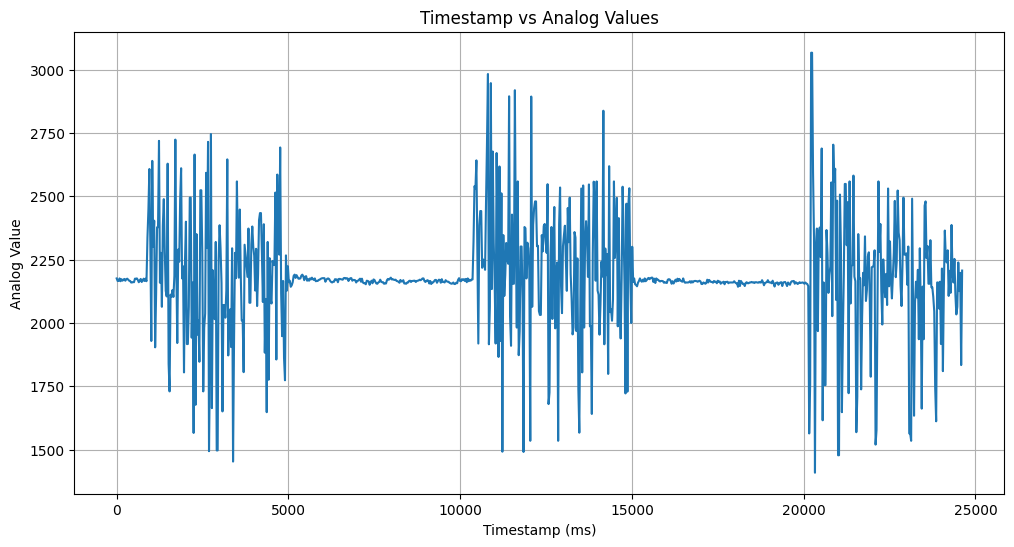

In [153]:
# An example of one set of analog values of raw data
sample_structured_file = cwd + '\\' + 'sample_data' + '\\' + 'structured' + '\\' + 'data1_structured.csv'

# plot timestamp vs analog values
df = pd.read_csv(sample_structured_file)
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['analog_value'])
plt.title('Timestamp vs Analog Values')
plt.xlabel('Timestamp (ms)')
plt.ylabel('Analog Value')
plt.grid()

# Prepare dataset and train

In [158]:
create_model_dataset(
    freq_domain_dir=cwd + '\\' + 'sample_data' + '\\' + 'processed',
    output_dir=cwd + '\\' + 'model_data'
)


background: 42 train, 8 val, 10 test
shout: 94 train, 20 val, 21 test


In [159]:
X_train, y_train, n_features = load_dataset_with_features(cwd + '\\model_data', 'train')
X_val, y_val, _ = load_dataset_with_features(cwd + '\\model_data', 'validation')
X_test, y_test, _ = load_dataset_with_features(cwd + '\\model_data', 'test')

rf = RandomForestClassifier(n_estimators=100, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Voting ensemble
voting_model = VotingClassifier(
    estimators=[('rf', rf), ('gb', gb)],
    voting='soft'
)
voting_model.fit(X_train, y_train)

# Validate model
y_val_pred = voting_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=['background', 'shout']))

# Test model
y_test_pred = voting_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['background', 'shout']))

train set: 136 samples, 13 features (fixed length)
validation set: 28 samples, 13 features (fixed length)
test set: 31 samples, 13 features (fixed length)
Validation Accuracy: 0.7500
Validation Classification Report:
              precision    recall  f1-score   support

  background       0.56      0.62      0.59         8
       shout       0.84      0.80      0.82        20

    accuracy                           0.75        28
   macro avg       0.70      0.71      0.70        28
weighted avg       0.76      0.75      0.75        28

Test Accuracy: 0.6774
Test Classification Report:
              precision    recall  f1-score   support

  background       0.50      0.40      0.44        10
       shout       0.74      0.81      0.77        21

    accuracy                           0.68        31
   macro avg       0.62      0.60      0.61        31
weighted avg       0.66      0.68      0.67        31

